# 1. Imports

In [65]:
import json
import warnings
from pathlib import Path
from copy import deepcopy

import pandas as pd
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerTuple
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
color_map = cmocean.cm.ice
import seaborn as sns

from applefy.detections.contrast import Contrast
from applefy.detections.uncertainty import compute_detection_uncertainty
from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio
from applefy.utils.contrast_grid import compute_contrast_from_grid
from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, fpf_2_gaussian_sigma, gaussian_sigma_2_fpf

from s4hci.detection_limits.applefy_wrapper import cADIDataReductionGPU, \
    PCADataReductionGPU, S4DataReduction
from s4hci.utils.data_handling import read_s4hci_root_dir
from s4hci.utils.setups import contrast_grid_setup_1

# 2. Load the dataset

In [2]:
dataset_name = "HD22049_303_199_C-0065_C_"
root_dir = Path(read_s4hci_root_dir())
json_file = root_dir / Path("30_data/" + dataset_name + ".json")

Data in the S4HCI_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
experiment_root_dir = root_dir / Path("70_results/x1_fake_planet_experiments/" + dataset_name)
experiment_root_dir.mkdir(exist_ok=True)

In [4]:
with open(json_file) as f:
    parameter_config = json.load(f)

dit_psf_template = float(parameter_config["dit_psf"])
dit_science = float(parameter_config["dit_science"])
fwhm = float(parameter_config["fwhm"])
scaling_factor = float(parameter_config["nd_scaling"])
lambda_reg = float(parameter_config["lambda_reg"])
svd_approx = int(parameter_config["svd_approx"])
pixel_scale=0.02718

In [5]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")

In [6]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [7]:
# we want the image to show the innermost 1.2 arcsec
print(1.2 / pixel_scale * 2)

88.30022075055187


In [8]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

# 3. Create Contrast Instance

In [9]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=scaling_factor,
    checkpoint_dir=experiment_root_dir)

In [10]:
# get fake planet setup
flux_ratios, separations, num_fake_planets = contrast_grid_setup_1(fwhm)

In [11]:
contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


# 4. Compute cADI limits (raw contrast) 

In [12]:
cadi_algorithm_function = cADIDataReductionGPU("cpu")

In [13]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=cadi_algorithm_function,
    num_parallel=1)

Running fake planet experiments...

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:06<00:00, 136.84it/s]

[DONE]


In [14]:
# for cADI the more stable mode "F" for the planet signal seems to cause problems
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=AperturePhotometryMode("P"),
    photometry_mode_noise=AperturePhotometryMode("P"))

In [15]:
contrast_grids = contrast_instance.compute_contrast_grids(
    statistical_test=TTest(),
    num_cores=32,
    num_rot_iter=10,
    compute_snr_grid=True,
    safety_margin=2.5,
    pixel_scale=pixel_scale)

Computing contrast grid for cADI
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]


In [16]:
tmp_contrast_grid = contrast_grids["cADI"]
tmp_contrast_grid_fpf = tmp_contrast_grid.applymap(gaussian_sigma_2_fpf)
cADI_contrast_curve = compute_contrast_from_grid(
    tmp_contrast_grid_fpf.fillna(1e-2), 
    gaussian_sigma_2_fpf(5))

# 5. Restore PCA and $S^4$ results

## 5.1 Restore PCA results

In [17]:
pca_numbers = np.concatenate(
    [np.arange(0, 30, 2)[1:],
     np.arange(30, 100, 10),
     np.arange(100, 200, 20),
     np.arange(200, 550, 50)])

pca_algorithm_function = PCADataReductionGPU(
        approx_svd=8000,
        pca_numbers=pca_numbers,
        device="cpu",
        work_dir=None,
        special_name="stacked_05",
        verbose=False)

In [18]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=pca_algorithm_function,
    num_parallel=1)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [03:40<00:00,  4.30it/s]

[DONE]


## 5.2 Restore $S^4$ results

In [19]:
for lambda_reg, special_name in [
    (100, "lambda_000100"),
    (1000, "lambda_001000"),
    (10000, "lambda_010000"),
    (100000, "lambda_100000")]:
    
    s4_model = S4DataReduction(
        device="cpu",
        lambda_reg=lambda_reg,
        special_name=special_name,
        rotation_grid_down_sample=1,
        logging_interval=50,
        save_models=True,
        train_num_epochs=500,
        noise_cut_radius_psf=fwhm,
        noise_mask_radius=1.5*fwhm,
        work_dir=None,
        verbose=False)

    # We have to keep track of the pca results to not loose them
    old_results = contrast_instance.results_dict
    contrast_instance.run_fake_planet_experiments(
        algorithm_function=s4_model,
        num_parallel=1)
    contrast_instance.results_dict.update(old_results)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:13<00:00, 68.85it/s]


[DONE]
Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:13<00:00, 69.15it/s]


[DONE]
Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:13<00:00, 68.78it/s]


[DONE]
Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:13<00:00, 67.63it/s]

[DONE]


# 4. Compute the contrast grids

In [20]:
# Use pixel values spaced by the FWHM
photometry_mode_planet = AperturePhotometryMode("F")
photometry_mode_noise = AperturePhotometryMode("P")

In [21]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    contrast_grids = contrast_instance.compute_contrast_grids(
        statistical_test=TTest(),
        num_cores=32,
        num_rot_iter=10,
        compute_snr_grid=True,
        safety_margin=2.5,
        pixel_scale=pixel_scale)

Computing contrast grid for s4_mean_lambda_100000
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for s4_median_lambda_100000
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for s4_mean_lambda_010000
Computing contrast grid with multiprocessing:
..................................................................

...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_026_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_028_components
Computing contrast grid with multiprocessing:
....................................................................................................................................................

...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_450_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_500_components
Computing contrast grid with multiprocessing:
....................................................................................................................................................

# 6. Plot an example of a Contrast Grid

In [46]:
def plot_contrast_grid(
    contrast_grid_axis,
    colorbar_axis,
    contrast_grid):

    c_bar_kargs = dict(
        orientation = "vertical",
        label = r"SNR [$T_{obs}$]")

    heat = sns.heatmap(
        contrast_grid,
        vmax=2, vmin=7,
        annot=True,
        cmap="YlGnBu",
        ax=contrast_grid_axis,
        cbar_ax=colorbar_axis,
        cbar_kws=c_bar_kargs)

    ylabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)
    xlabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_xticklabels()]
    _=heat.set_xticklabels(xlabels)

In [47]:
tmp_contrast_grid = deepcopy(contrast_grids['stacked_05_PCA_010_components'])
tmp_contrast_grid.index = flux_ratio2mag(tmp_contrast_grid.index)

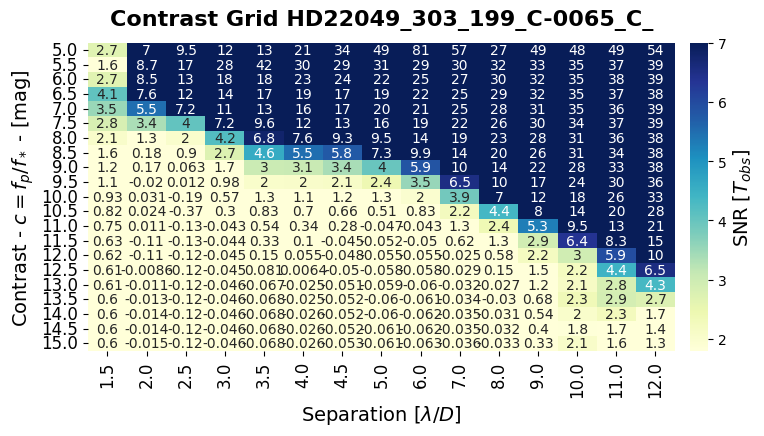

In [48]:
fig = plt.figure(figsize=(8, 4))

gs0 = fig.add_gridspec(1, 1)
gs0.update(wspace=0.0, hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec = gs0[0],
    wspace=0.05, width_ratios=[1, 0.03])

# All axis we need
contrast_ax = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs1[1])

# Plot the contrast grid
plot_contrast_grid(
    contrast_grid_axis=contrast_ax,
    colorbar_axis=colorbar_ax,
    contrast_grid=tmp_contrast_grid)

colorbar_ax.yaxis.label.set_size(14)

contrast_ax.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
contrast_ax.set_xlabel(
    r"Separation [$\lambda /D$]", size=14)
contrast_ax.set_title(
    "Contrast Grid " + dataset_name,
    fontsize=16,
    fontweight="bold",
    y=1.03)

contrast_ax.tick_params(
    axis='both',
    which='major',
    labelsize=12)

# Save the figure
fig.patch.set_facecolor('white')

# 7. Get the S/N = 5 limits from contrast grids

## 7.1 Threshold the PCA result

In [49]:
pca_results = dict()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for tmp_pca_number in pca_numbers:
        tmp_contrast_grid = contrast_grids["stacked_05_PCA_" + str(tmp_pca_number).zfill(3) + "_components"]
        tmp_contrast_grid_fpf = tmp_contrast_grid.applymap(gaussian_sigma_2_fpf)
        tmp_contrast_curve = compute_contrast_from_grid(
            tmp_contrast_grid_fpf.fillna(1e-2), 
            gaussian_sigma_2_fpf(5))
        pca_results[tmp_pca_number] = tmp_contrast_curve.applymap(flux_ratio2mag)

In [50]:
pca_results = pd.concat(pca_results.values(), keys=pca_results.keys(), axis=1)
pca_results.index = np.round(pca_results.index, 2)
pca_results.columns = pca_results.columns.get_level_values(0)
pca_results

,2,4,6,8,10,12,14,16,18,20,...,140,160,180,200,250,300,350,400,450,500
separation,,,,,,,,,,,,,,,,,,,,,
1.5,5.386410,5.810471,NaN,6.434691,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,5.494310,6.826542,6.808872,6.851682,7.116012,6.609762,6.932342,6.855992,7.077262,6.942232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.5,6.088321,6.773242,7.075212,7.185542,7.347172,7.602833,8.060823,8.093953,7.835643,7.591503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,6.621442,7.157122,7.634763,7.595383,7.867413,8.338253,8.411613,8.550294,8.397303,8.084933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.5,7.168492,7.863943,8.180973,8.282813,8.406273,8.556154,8.647144,8.749204,8.862474,8.908924,...,9.305484,8.898684,9.074434,8.501714,NaN,NaN,NaN,NaN,NaN,NaN
4.0,7.704843,8.246723,8.429953,8.565364,8.600574,8.703274,8.844484,8.887704,9.023454,9.290754,...,9.931665,9.779235,9.625295,9.346804,NaN,NaN,NaN,NaN,NaN,NaN
4.5,7.768533,8.300053,8.442573,8.648464,8.661514,8.789054,8.904254,8.952474,9.071894,9.289974,...,10.630776,10.320435,10.600776,9.806195,9.026234,NaN,NaN,NaN,NaN,NaN
5.0,7.955043,8.463373,8.735454,8.819514,8.849254,8.921594,9.125644,9.187944,9.286554,9.448104,...,11.337336,10.855826,10.926546,11.058566,10.423415,8.970894,NaN,NaN,NaN,NaN
6.0,8.224383,8.798564,8.969184,9.097344,9.183114,9.343194,9.388464,9.482934,9.587405,9.720565,...,11.287256,11.414196,11.545327,11.665837,11.335926,10.861636,10.072005,9.552405,NaN,NaN


## 7.2 Get the optimal PCA

In [51]:
overall_best_pca = pca_results.max(axis=1)

## 7.3 Threshold the $S^4$ result

In [52]:
s4_lambdas = [100, 1000, 10000, 100000]

In [53]:
s4_results = dict()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for tmp_lambda in s4_lambdas:
        for tmp_combine in ["mean", "median"]:
            tmp_contrast_grid = contrast_grids["s4_" + tmp_combine + "_lambda_" + str(tmp_lambda).zfill(6)]
            tmp_contrast_grid_fpf = tmp_contrast_grid.applymap(gaussian_sigma_2_fpf)
            tmp_contrast_curve = compute_contrast_from_grid(
                tmp_contrast_grid_fpf.fillna(1e-2), 
                gaussian_sigma_2_fpf(5))
            s4_results["s4_" + tmp_combine + "_lambda_" + str(tmp_lambda).zfill(6)] = tmp_contrast_curve.applymap(flux_ratio2mag)

In [54]:
s4_results = pd.concat(s4_results.values(), keys=s4_results.keys(), axis=1)
s4_results.index = np.round(s4_results.index, 2)
s4_results.columns = s4_results.columns.get_level_values(0)
s4_results

,s4_mean_lambda_000100,s4_median_lambda_000100,s4_mean_lambda_001000,s4_median_lambda_001000,s4_mean_lambda_010000,s4_median_lambda_010000,s4_mean_lambda_100000,s4_median_lambda_100000
separation,,,,,,,,
1.5,7.754753,7.691523,7.391852,7.527673,6.970162,7.307332,7.315842,7.022312
2.0,8.873674,8.809014,8.466453,8.466733,8.324583,8.253643,8.239603,8.171803
2.5,9.441664,9.379544,9.182834,9.129434,9.023964,8.889724,8.982914,8.877884
3.0,9.697745,9.822025,9.806295,9.811395,9.734145,9.683285,9.587305,9.547245
3.5,10.420645,10.347075,10.245315,10.290805,NaN,10.100705,NaN,NaN
4.0,10.904436,10.829916,10.733326,10.699976,10.597986,10.568046,10.482625,10.446745
4.5,10.971196,10.996796,10.952476,10.959406,10.800516,10.825776,10.657936,10.700826
5.0,11.654087,11.529617,11.528957,11.448176,11.082666,11.142876,10.896576,11.020666
6.0,11.702727,11.741847,11.686167,11.733187,11.480166,11.535657,11.339346,11.389476


In [55]:
s4_contrast = s4_results["s4_mean_lambda_000100"]

# 8. Plot the S/N = 5 curves

In [56]:
separations_FWHM = s4_results.index
separations_arcsec = s4_results.index * pixel_scale * fwhm

In [57]:
# Find one color for each number of PCA components used.
colors = sns.color_palette("rocket_r", 
    n_colors=pca_results.shape[1])
colors

[(0.97628674, 0.87986189, 0.8057883),
 (0.97169389, 0.83320847, 0.73716071),
 (0.96850919, 0.79222565, 0.6764046),
 (0.96612013, 0.74451182, 0.60871954),
 (0.96504223, 0.7015636, 0.5528892),
 (0.96403203, 0.65122535, 0.4932578),
 (0.96276513, 0.60612062, 0.44471698),
 (0.96042097, 0.55328624, 0.39319057),
 (0.9573439, 0.50573243, 0.35130912),
 (0.9524044, 0.44944853, 0.3072105),
 (0.94625977, 0.39813168, 0.27489742),
 (0.93599076, 0.33703942, 0.24972157),
 (0.92223947, 0.28287251, 0.24229568),
 (0.8985026, 0.22463251, 0.25108745),
 (0.87079129, 0.17982114, 0.26797378),
 (0.83355779, 0.13511035, 0.29057852),
 (0.79085854, 0.10184672, 0.313391),
 (0.74919318, 0.08820542, 0.33107204),
 (0.69803757, 0.08897226, 0.3462986),
 (0.65154562, 0.09680192, 0.35454107),
 (0.59770215, 0.10693774, 0.35838029),
 (0.5506426, 0.11420757, 0.35737863),
 (0.49742847, 0.11955087, 0.35206533),
 (0.45158266, 0.12158557, 0.34406324),
 (0.40002537, 0.12134964, 0.33102734),
 (0.355676, 0.11910909, 0.31620996),
 (0.30592213, 0.11432553, 0.29542718),
 (0.26326851, 0.1081815, 0.27401148),
 (0.21560818, 0.09882993, 0.24611154),
 (0.17489524, 0.08848235, 0.2190294),
 (0.12938228, 0.07383015, 0.18636053),
 (0.09011319, 0.05808059, 0.15797687),
 (0.04447016, 0.03648425, 0.12631831)]

In [58]:
# Examples for later
example_1 = (1.5, 7.5, 0)
example_2 = (2.5, 9.5, 2)
example_3 = (11., 13., 1)

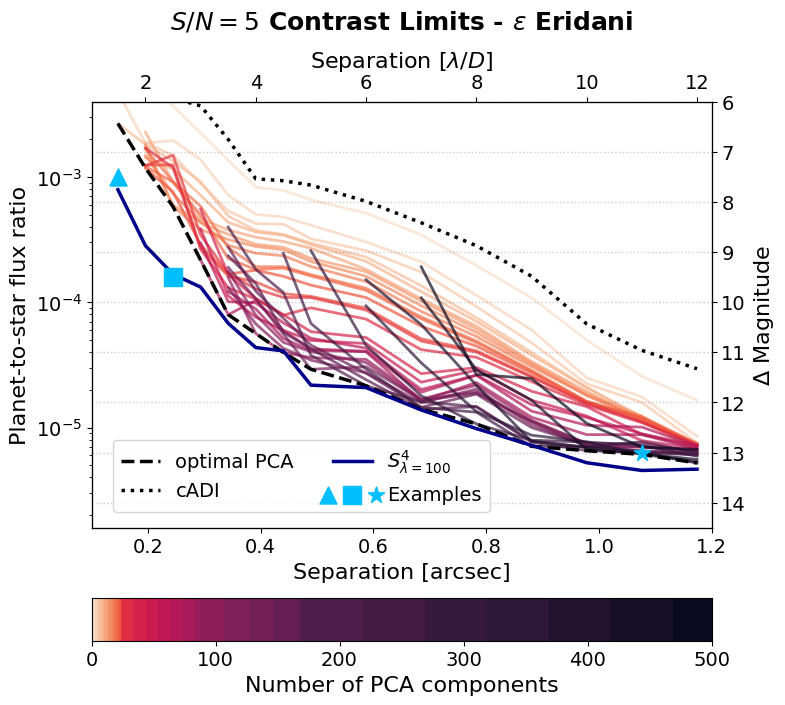

In [59]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(8, 7))
gs0 = fig.add_gridspec(2, 1, height_ratios=[1, 0.1], hspace=0.3)
axis_contrast_curvse = fig.add_subplot(gs0[0, 0])

# ------------------- Create the PCA number legend -----------
axis_legend_lines = fig.add_subplot(gs0[1, 0])

for idx, tmp_components in enumerate(
    pca_results.columns.values):
    if tmp_components < 30:
        lw=3
    elif tmp_components < 100:
        lw=12
    elif tmp_components < 200:
        lw=24
    else:
        lw=57
    axis_legend_lines.vlines(
        [tmp_components], 
        ymin=0, ymax=1, color=colors[idx],
        lw=lw)
    
axis_legend_lines.set_xlim(0, 500)
axis_legend_lines.set_ylim(0, 1)
axis_legend_lines.set_yticks([])
axis_legend_lines.tick_params(
    axis='both', which='major', labelsize=14)
axis_legend_lines.set_xlabel("Number of PCA components", size=16)


# ---------------------- Create the PCA plots --------------------
i = 0 # color picker

for pca_number, tmp_contrast_mag in pca_results.items():
    axis_contrast_curvse.plot(
        separations_arcsec,
        mag2flux_ratio(tmp_contrast_mag),
        color = colors[i],
        lw=2,
        alpha=0.7)
    i+=1

axis_contrast_curvse.set_yscale("log")

# ----------- Plot the best PCA contrast -------------------------
pca_plot = axis_contrast_curvse.plot(
    separations_arcsec,
    mag2flux_ratio(overall_best_pca),
    color = "black",
    lw=2.5,
    label="optimal PCA",
    ls="dashed")

# ----------- Plot the raw contrast -------------------------
pca_plot = axis_contrast_curvse.plot(
    separations_arcsec[1:],
    cADI_contrast_curve.values[1:],
    color = "black",
    lw=2.5,
    label="cADI",
    ls="dotted")

# ----------- Plot the S4 contrast --------------------------
s4_plot = axis_contrast_curvse.plot(
    separations_arcsec,
    mag2flux_ratio(s4_contrast),
    color = "darkblue",
    lw=2.5,
    label="$S^4_{\lambda=100}$",
    ls="-")

# ------------- Double axis and limits -----------------------
lim_mag_y = (14.5, 6)
lim_arcsec_x = (0.1, 1.2)

sep_lambda_arcse = interpolate.interp1d(
    separations_arcsec,
    separations_FWHM,
    fill_value='extrapolate')

axis_contrast_curvse_mag = axis_contrast_curvse.twinx()
axis_contrast_curvse_mag.plot(
    separations_arcsec,
    s4_contrast,
    alpha=0.)
axis_contrast_curvse_mag.invert_yaxis()

axis_contrast_curvse_lambda = axis_contrast_curvse.twiny()
axis_contrast_curvse_lambda.plot(
    separations_FWHM,
    mag2flux_ratio(s4_contrast),
    alpha=0.)

axis_contrast_curvse_mag.grid(
    which='major', ls="dotted", lw=1,
    alpha=0.2, color="black", zorder=0)
axis_contrast_curvse_mag.set_ylim(*lim_mag_y)
axis_contrast_curvse.set_ylim(
    mag2flux_ratio(lim_mag_y[0]),
    mag2flux_ratio(lim_mag_y[1]))

axis_contrast_curvse.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_mag.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_lambda.set_xlim(
    *sep_lambda_arcse(lim_arcsec_x))

# ------------- Examples -----------------------
ex1=axis_contrast_curvse.scatter(
    [example_1[0] * fwhm * pixel_scale],
    [mag2flux_ratio(example_1[1])],
    s=150,
    color="deepskyblue",
    marker="^",
    zorder=10)

ex2=axis_contrast_curvse.scatter(
    [example_2[0] * fwhm * pixel_scale],
    [mag2flux_ratio(example_2[1])],
    s=150,
    color="deepskyblue",
    marker="s",
    zorder=10)

ex3=axis_contrast_curvse.scatter(
    [example_3[0] * fwhm * pixel_scale],
    [mag2flux_ratio(example_3[1])],
    s=150,
    color="deepskyblue",
    marker="*",
    zorder=10)

# ----------- Labels and fontsizes --------------------------

axis_contrast_curvse.set_xlabel(
    r"Separation [arcsec]", size=16)
axis_contrast_curvse_lambda.set_xlabel(
    r"Separation [$\lambda/D$]", size=16)

axis_contrast_curvse.set_ylabel(
    r"Planet-to-star flux ratio", size=16)
axis_contrast_curvse_mag.set_ylabel(
    r"$\Delta$ Magnitude", size=16)

axis_contrast_curvse.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_lambda.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_mag.tick_params(
    axis='both', which='major', labelsize=14)

axis_contrast_curvse_mag.set_title(
    r"$S/N = 5$ Contrast Limits - $\epsilon$ Eridani",
    fontsize=18, fontweight="bold", y=1.15)

# --------------------------- Legend -----------------------
handles, labels = axis_contrast_curvse.\
    get_legend_handles_labels()

labels.append("Examples")

# Create a legend with grouped markers and line plot
legend_elements = [
    handles[0],
    handles[1],
    handles[2],
    (ex1, ex2, ex3)]

# Add legend
leg1 = fig.legend(legend_elements, labels,
                  bbox_to_anchor=(0.14, 0.28),
                  fontsize=14,
                  handler_map={tuple: HandlerTuple(ndivide=None, pad=1.7)},
                  loc='lower left', ncol=2)

_=plt.setp(leg1.get_title(),fontsize=14)
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/05_contrast_limits.pdf", bbox_inches='tight')

In [60]:
# the contrast improvement compared to cADI! [mag]
(s4_contrast.values[1:] - flux_ratio2mag(cADI_contrast_curve.values.flatten()[1:]))

array([3.50935351, 3.51034351, 3.61590362, 3.66838367, 3.36663337,
       3.39481339, 3.99031399, 3.71503372, 3.73565374, 3.64799365,
       3.37367337, 2.76830277, 2.3965824 , 2.003802  ])

# 9. Plot example residuals

In [61]:
best_number_of_components = pca_results.T.idxmax().values

In [62]:
magnitudes = flux_ratio2mag(contrast_grids["s4_mean_lambda_000100"].index)

example_1_idx_sep = np.where(separations_FWHM == example_1[0])[0][0]
example_1_idx_mag = np.where(magnitudes == example_1[1])[0][0]
example_1_pcas = best_number_of_components[example_1_idx_sep]

example_2_idx_sep = np.where(separations_FWHM == example_2[0])[0][0]
example_2_idx_mag = np.where(magnitudes == example_2[1])[0][0]
example_2_pcas = best_number_of_components[example_2_idx_sep]

example_3_idx_sep = np.where(separations_FWHM == example_3[0])[0][0]
example_3_idx_mag = np.where(magnitudes == example_3[1])[0][0]
example_3_pcas = best_number_of_components[example_3_idx_sep]

## 9.1 Get the residual images

In [63]:
s4_residuals = contrast_instance.contrast_results["s4_mean_lambda_000100"].residuals
s4_residual_1 = s4_residuals[example_1_idx_sep, example_1_idx_mag, example_1[2]]
s4_residual_2 = s4_residuals[example_2_idx_sep, example_2_idx_mag, example_2[2]]
s4_residual_3 = s4_residuals[example_3_idx_sep, example_3_idx_mag, example_3[2]]

In [64]:
tmp_residuals = contrast_instance.contrast_results[
    "stacked_05_PCA_" + str(example_1_pcas).zfill(3) +"_components"].residuals
pca_residual_1 = tmp_residuals[example_1_idx_sep, example_1_idx_mag, example_1[2]]

tmp_residuals = contrast_instance.contrast_results[
    "stacked_05_PCA_" + str(example_2_pcas).zfill(3) +"_components"].residuals
pca_residual_2 = tmp_residuals[example_2_idx_sep, example_2_idx_mag, example_2[2]]

tmp_residuals = contrast_instance.contrast_results[
    "stacked_05_PCA_" + str(example_3_pcas).zfill(3) +"_components"].residuals
pca_residual_3 = tmp_residuals[example_3_idx_sep, example_3_idx_mag, example_3[2]]

## 9.2 compute the S/N

In [191]:
def get_snr(
    method_name,
    example):
    
    contrast_result = contrast_instance.contrast_results[method_name]
    contrast_result.idx_table.index = np.round(contrast_result.idx_table.index, 2)
    example_idx = contrast_result.idx_table[mag2flux_ratio(example[1])][example[0] * fwhm]
    residual, position = contrast_result.planet_dict[example_idx][example[2]]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _, _, snr = compute_detection_uncertainty(
            frame=residual,
            planet_position=position, 
            statistical_test=TTest(),
            psf_fwhm_radius=fwhm,
            photometry_mode_planet=photometry_mode_planet,
            photometry_mode_noise=photometry_mode_noise,
            safety_margin=2.5,
            num_rot_iter=20)
        snr = snr[~np.isnan(snr)]
    
    return np.median(snr)

In [192]:
pca_example_1_snr = np.round(
    get_snr("stacked_05_PCA_" + str(example_1_pcas).zfill(3) +"_components",
            example_1), 2)

pca_example_2_snr = np.round(
    get_snr("stacked_05_PCA_" + str(example_2_pcas).zfill(3) +"_components",
            example_2), 2)

pca_example_3_snr = np.round(
    get_snr("stacked_05_PCA_" + str(example_3_pcas).zfill(3) +"_components",
            example_3), 2)

s4_example_1_snr = np.round(get_snr("s4_mean_lambda_000100", example_1), 2)

s4_example_2_snr = np.round(get_snr("s4_mean_lambda_000100", example_2), 2)

s4_example_3_snr = np.round(get_snr("s4_mean_lambda_000100", example_3), 2)

In [193]:
def add_colorbar(axis_in, plot_in, left=True):
    if left:
        tick_side = "left"
    else:
        tick_side = "right"
    divider = make_axes_locatable(axis_in)
    cax = divider.new_horizontal(size="5%", pad=0.1, pack_start=left)
    fig.add_axes(cax)
    
    cbar = fig.colorbar(plot_in, cax=cax, 
                 orientation="vertical")
    cbar.ax.yaxis.set_ticks_position(tick_side)
    axis_in.set_xticks([]) 
    axis_in.set_yticks([]) 
    cbar.ax.tick_params(labelsize=10)

In [197]:
def annotate_pca(axis_in, num_pca, snr):
    t2 = axis_in.annotate(
    xytext=(5., 9.),
    xy=(0, 0),
    text=str(num_pca) + " components; S/N = " + str(snr),
    color='w',
    va='top',
    ha='left',
    fontsize=10,
    bbox=dict(facecolor='black', 
          edgecolor='none',
          boxstyle='round',
          alpha=0.5))
    
def annotate_s4(axis_in, snr):
    t2 = axis_in.annotate(
    xytext=(5., 9.),
    xy=(0, 0),
    text="S/N = " + str(snr),
    color='w',
    va='top',
    ha='left',
    fontsize=10,
    bbox=dict(facecolor='black', 
          edgecolor='none',
          boxstyle='round',
          alpha=0.5))

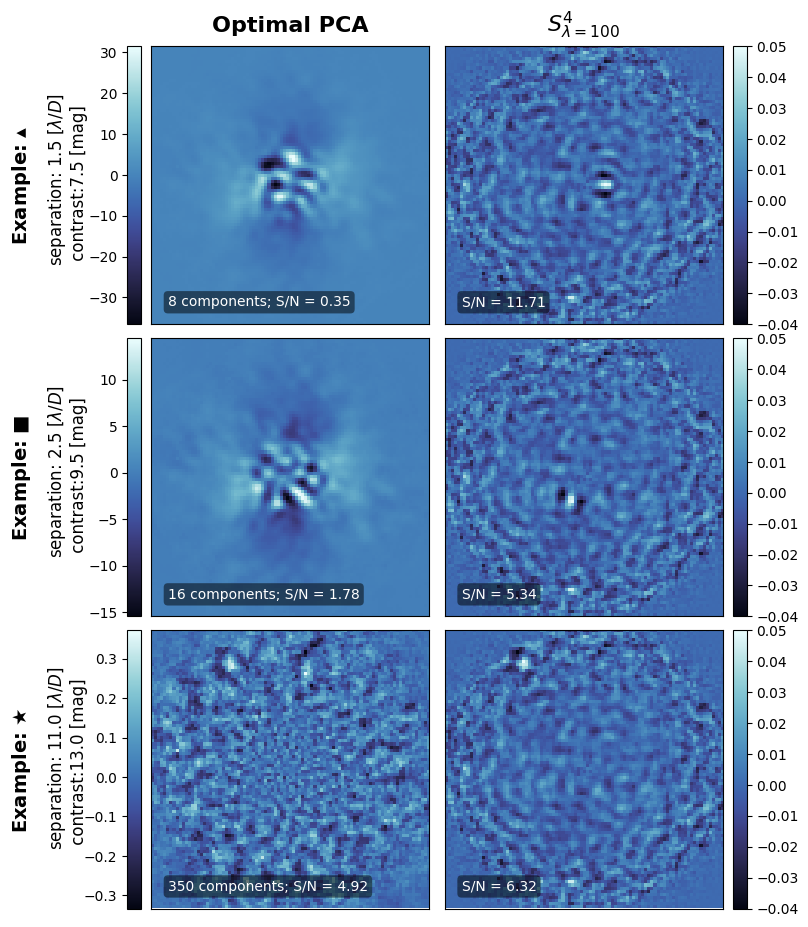

In [198]:
fig = plt.figure(constrained_layout=False, figsize=(8, 11.2))
gs0 = fig.add_gridspec(3, 2,hspace=0.05, wspace=0.05) # height_ratios=[1, 1]

axis_pca_1 = fig.add_subplot(gs0[0, 0])
axis_pca_2 = fig.add_subplot(gs0[1, 0])
axis_pca_3 = fig.add_subplot(gs0[2, 0])
axis_s4_1 = fig.add_subplot(gs0[0, 1])
axis_s4_2 = fig.add_subplot(gs0[1, 1])
axis_s4_3 = fig.add_subplot(gs0[2, 1])

# PCA plots -----------------
plot1 = axis_pca_1.imshow(pca_residual_1, cmap=color_map, origin='lower')
add_colorbar(axis_pca_1, plot1, True)
annotate_pca(axis_pca_1, example_1_pcas, pca_example_1_snr)
plot2 = axis_pca_2.imshow(pca_residual_2, cmap=color_map, origin='lower')
add_colorbar(axis_pca_2, plot2, True)
annotate_pca(axis_pca_2, example_2_pcas, pca_example_2_snr)
plot3 = axis_pca_3.imshow(pca_residual_3, cmap=color_map, origin='lower')
add_colorbar(axis_pca_3, plot3, True)
annotate_pca(axis_pca_3, example_3_pcas, pca_example_3_snr)

# S4 plots -----------------
plot4 = axis_s4_1.imshow(s4_residual_1, cmap=color_map, origin='lower',
                         vmin=-0.04, vmax=0.05)
add_colorbar(axis_s4_1, plot4, False)
annotate_s4(axis_s4_1, s4_example_1_snr)
plot5 = axis_s4_2.imshow(s4_residual_2, cmap=color_map, origin='lower',
                         vmin=-0.04, vmax=0.05)
add_colorbar(axis_s4_2, plot5, False)
annotate_s4(axis_s4_2, s4_example_2_snr)
plot6 = axis_s4_3.imshow(s4_residual_3, cmap=color_map, origin='lower',
                         vmin=-0.04, vmax=0.05)
add_colorbar(axis_s4_3, plot6, False)
annotate_s4(axis_s4_3, s4_example_3_snr)

# Titles -----------------
axis_pca_1.set_title("Optimal PCA", fontsize=16, fontweight="bold", y=1.02)
axis_s4_1.set_title("$S^4_{\lambda=100}$", fontsize=16, fontweight="bold", y=1.02)

axis_pca_1.set_ylabel(
    r"Example: $\blacktriangle$", fontsize=14, 
    fontweight="bold",labelpad=85)
axis_pca_1.text(
    -35, 20, 
    "separation: " + str(example_1[0]) + " [$\lambda/D$] \n contrast:" + str(example_1[1]) + " [mag]",
    fontsize=12, rotation=90)

axis_pca_2.set_ylabel(
    r"Example: $\blacksquare$", fontsize=14, 
    fontweight="bold",labelpad=85)
axis_pca_2.text(
    -35, 20, 
    "separation: " + str(example_2[0]) + " [$\lambda/D$] \n contrast:" + str(example_2[1]) + " [mag]",
    fontsize=12, rotation=90)

axis_pca_3.set_ylabel(
    r"Example: $\bigstar$", fontsize=14, 
    fontweight="bold",labelpad=85)
axis_pca_3.text(
    -35, 20, 
    "separation: " + str(example_3[0]) + " [$\lambda/D$] \n contrast:" + str(example_3[1]) + " [mag]",
    fontsize=12, rotation=90)

# Save the plot
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/05_residuals_PCA_S4.pdf", bbox_inches='tight')